In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas
import random
from itertools import combinations
from sklearn.model_selection import KFold

CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.size": 16,

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 1.5,
    "lines.linewidth": 1.5,
    # "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none",
    "savefig.dpi": 300,

    # Higher DPI for sharper inline images
    "figure.dpi": 96
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

# Get the data
data1 = np.loadtxt("HARPS.dat")
data2 = np.loadtxt("HIRES.dat")
data = np.vstack((data1,data2))
print(len(data1),' HARPS points; ',len(data2),' HIRES points')

# Add on jitter (additional noise term)
jitter = 1.2
for i in range(len(data)):
    data[i,2] = np.sqrt( data[i,2]**2 + jitter**2 )

# Initial information from Vogt et al. (2010)
initial_params = {
    "b": {
        "P_sol": 5.36841,
        "P_del": 0.00026,
        "K_sol": 12.45
    },
    "c": {
        "P_sol": 12.9191,
        "P_del": 0.0058,
        "K_sol": 3.30
    },
    "d": {
        "P_sol": 66.87,
        "P_del": 0.13,
        "K_sol": 1.91
    },
    "e": {
        "P_sol": 3.14867,
        "P_del": 0.00039,
        "K_sol": 1.66
    },
    "f": {
        "P_sol": 433.0,
        "P_del": 13.0,
        "K_sol": 1.30
    },
    "g": {
        "P_sol": 36.562,
        "P_del": 0.052,
        "K_sol": 1.29
    }
}

119  HARPS points;  122  HIRES points


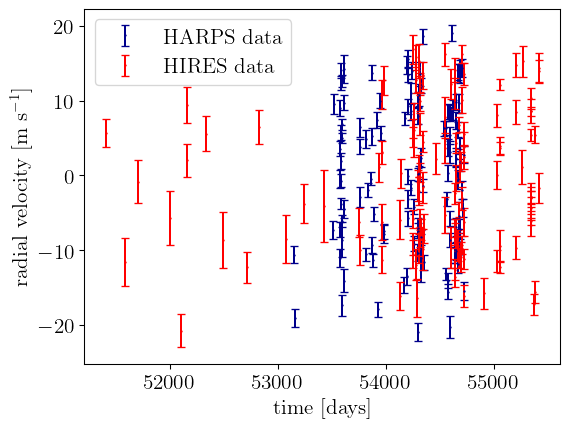

In [2]:
time1 = data1[:,0]
vel1 = data1[:,1]
velerr1 = data1[:,2]
time2 = data2[:,0]
vel2 = data2[:,1]
velerr2 = data2[:,2]

plt.errorbar(time1, vel1, yerr=velerr1, fmt='.', capsize=3, color='darkblue', label='HARPS data')
plt.errorbar(time2, vel2, yerr=velerr2, fmt='.', capsize=3, color='red', label='HIRES data')
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m s$^{-1}$]")
plt.legend()
plt.savefig('data_plot.svg')
plt.show()

In [3]:
#separate into fitting and crossval data
# Function to generate n different random integers within a specified range
def generate_random_integers(n, start, end):
    # Check for invalid inputs
    if n <= 0 or start >= end:
        return []
    # Create a set to store unique integers
    unique_integers = set()
    # Generate random integers until we have n unique ones
    while len(unique_integers) < n:
        unique_integers.add(random.randint(start, end))
    # Convert the set to a list and return it
    return list(unique_integers)

crossval_fraction = 0.2
random_integers = generate_random_integers(np.floor(crossval_fraction*len(data)), 0, len(data)-1)

inds = np.linspace(0, len(data)-1, len(data))
inds = [int(x) for x in inds]
for i in random_integers:
    if i in inds:
        inds.remove(i)

keep = data[inds]
crossval = data[random_integers]

#data = keep

In [4]:
#model comparison metrics
def reduced_chi2(chi2, n, k):
    return chi2/(n-k)

def BIC(chi2, n, k):
    return chi2 + k*np.log(n)

def AIC(chi2, k):
    return chi2 + 2*k

def mod_AIC(chi2, n, k):
    return AIC(chi2, k) + (2*k**2 + 2*k)/(n - k - 1)

def BIC_bayes(bic1, bic2):
    return np.exp(-0.5*(bic1-bic2))

In [5]:
# Define model M0 = 4-planet model
def M04(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe):
        return Kb*np.sin(2.0*np.pi*t/Pb+qb) \
               + Kc*np.sin(2.0*np.pi*t/Pc+qc) \
               + Kd*np.sin(2.0*np.pi*t/Pd+qd) \
               + Ke*np.sin(2.0*np.pi*t/Pe+qe)

def fullfit_4(data):
        # A full fit is tricky because it's not obvious where to initalize the phases (q) from
    # So let's run a pre-fit first, wherXe we only allow the phases to vary
    # Trying running this a few times and make sure the same solution is coming out

    # Define model M0 fix = 4-planet model using K & P parameters fixed to the Vogt+ reported values
    def M0fix(t, qb, qc, qd, qe):
        return initial_params["b"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["b"]["P_sol"]+qb) \
               + initial_params["c"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["c"]["P_sol"]+qc) \
               + initial_params["d"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["d"]["P_sol"]+qd) \
               + initial_params["e"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["e"]["P_sol"]+qe)

    # Define our parameters bounds
    param_bounds = ( [-2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi],\
                     [2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi] )

    # Give an intial guess to help the fitting routine
    initial_guess = [ np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi)]

    # Get the best fitting parameters
    M0fix_best, M0fix_cov = curve_fit(M0fix,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)
    
    # OK, I'm satisfied the above chi2 looks reasonable, so set the phase solutions as initial guesses
    qb_sol = M0fix_best[0]
    qc_sol = M0fix_best[1]
    qd_sol = M0fix_best[2]
    qe_sol = M0fix_best[3]
    
    # Now we're ready to run the full 4-planet fit
    # Define our parameters bounds
    param_bounds = ( [0.0,  initial_params["b"]["P_sol"]-3.0*initial_params["b"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["c"]["P_sol"]-3.0*initial_params["c"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["d"]["P_sol"]-3.0*initial_params["d"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["e"]["P_sol"]-3.0*initial_params["e"]["P_del"], -2.0*np.pi,], \
                     [20.0, initial_params["b"]["P_sol"]+3.0*initial_params["b"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["c"]["P_sol"]+3.0*initial_params["c"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["d"]["P_sol"]+3.0*initial_params["d"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["e"]["P_sol"]+3.0*initial_params["e"]["P_del"],  2.0*np.pi,] )

    # Give an intial guess to help the fitting routine
    initial_guess =  [initial_params["b"]["K_sol"], initial_params["b"]["P_sol"], qb_sol,\
                      initial_params["c"]["K_sol"], initial_params["c"]["P_sol"], qc_sol,\
                      initial_params["d"]["K_sol"], initial_params["d"]["P_sol"], qd_sol,\
                      initial_params["e"]["K_sol"], initial_params["e"]["P_sol"], qe_sol]

    # Get the best fitting parameters
    M0_best, M0_cov = curve_fit(M04,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

    #return model parameters
    return[M0_best, M0_cov]

def model_eval_4(data, M0_best):
    # Get the chi2
    chi2 = 0.0
    for i in range(len(data)):
        chi2 = chi2 + ( ( data[i,1] - M04( data[i,0],\
                                          M0_best[0],M0_best[1],M0_best[2],\
                                          M0_best[3],M0_best[4],M0_best[5],\
                                          M0_best[6],M0_best[7],M0_best[8],\
                                          M0_best[9],M0_best[10],M0_best[11]) ) / data[i,2])**2
    # Get the loglike
    loglike = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2

    # Print output
    return[chi2,loglike]

In [6]:
num_planets = 4
n = len(data)
k = 3*num_planets
chi2 = model_eval_4(data, fullfit_4(data)[0])[0]
loglike = model_eval_4(data, fullfit_4(data)[0])[1]

model_4planets = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

chi2 = model_eval_4(crossval, fullfit_4(data)[0])[0]
loglike = model_eval_4(crossval, fullfit_4(data)[0])[1]

crossval_4 = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

In [7]:
print(model_4planets, crossval_4)

{'chi2': 390.3946366399389, 'loglike': -567.8480036699921, 'rchi2': 1.7047800726634885, 'bic': 456.21219984182676, 'aic': 414.3946366399389, 'maic': 415.76305769257044} {'chi2': 66.81146404311302, 'loglike': -106.77515866933913, 'rchi2': 0.2917531180921966, 'bic': 132.62902724500088, 'aic': 90.81146404311302, 'maic': 92.1798850957446}


In [8]:
# Define model M0 = 5-planet model
def M05f(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe, Kf, Pf, qf):
    return Kb*np.sin(2.0*np.pi*t/Pb+qb) \
           + Kc*np.sin(2.0*np.pi*t/Pc+qc) \
           + Kd*np.sin(2.0*np.pi*t/Pd+qd) \
           + Ke*np.sin(2.0*np.pi*t/Pe+qe) \
           + Kf*np.sin(2.0*np.pi*t/Pf+qf)

def fullfit_5f(data):
    #5 planet fit (f)
    # A full fit is tricky because it's not obvious where to initalize the phases (q) from
    # So let's run a pre-fit first, wherXe we only allow the phases to vary
    # Trying running this a few times and make sure the same solution is coming out

    # Define model M0 fix = 5-planet model using K & P parameters fixed to the Vogt+ reported values
    def M0fix(t, qb, qc, qd, qe, qf):
        return initial_params["b"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["b"]["P_sol"]+qb) \
               + initial_params["c"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["c"]["P_sol"]+qc) \
               + initial_params["d"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["d"]["P_sol"]+qd) \
               + initial_params["e"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["e"]["P_sol"]+qe) \
               + initial_params["f"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["f"]["P_sol"]+qf)

    # Define our parameters bounds
    param_bounds = ( [-2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi],\
                     [2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi] )

    # Give an intial guess to help the fitting routine
    initial_guess = [ np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi)]

    # Get the best fitting parameters
    M0fix_best, M0fix_cov = curve_fit(M0fix,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)
    
    # OK, I'm satisfied the above chi2 looks reasonable, so set the phase solutions as initial guesses
    qb_sol = M0fix_best[0]
    qc_sol = M0fix_best[1]
    qd_sol = M0fix_best[2]
    qe_sol = M0fix_best[3]
    qf_sol = M0fix_best[4]
    
    # Now we're ready to run the full 5-planet fit
    # Define our parameters bounds
    param_bounds = ( [0.0,  initial_params["b"]["P_sol"]-3.0*initial_params["b"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["c"]["P_sol"]-3.0*initial_params["c"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["d"]["P_sol"]-3.0*initial_params["d"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["e"]["P_sol"]-3.0*initial_params["e"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["f"]["P_sol"]-3.0*initial_params["f"]["P_del"], -2.0*np.pi,], \
                     [20.0, initial_params["b"]["P_sol"]+3.0*initial_params["b"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["c"]["P_sol"]+3.0*initial_params["c"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["d"]["P_sol"]+3.0*initial_params["d"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["e"]["P_sol"]+3.0*initial_params["e"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["f"]["P_sol"]+3.0*initial_params["f"]["P_del"],  2.0*np.pi,] )

    # Give an intial guess to help the fitting routine
    initial_guess =  [initial_params["b"]["K_sol"], initial_params["b"]["P_sol"], qb_sol,\
                      initial_params["c"]["K_sol"], initial_params["c"]["P_sol"], qc_sol,\
                      initial_params["d"]["K_sol"], initial_params["d"]["P_sol"], qd_sol,\
                      initial_params["e"]["K_sol"], initial_params["e"]["P_sol"], qe_sol,\
                      initial_params["f"]["K_sol"], initial_params["f"]["P_sol"], qf_sol]

    # Get the best fitting parameters
    M0_best, M0_cov = curve_fit(M05f,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)
    
    #return model parameters
    return[M0_best, M0_cov]

def model_eval_5f(data, M0_best):
    # Get the chi2
    chi2_5f = 0.0
    for i in range(len(data)):
        chi2_5f = chi2_5f + ( ( data[i,1] - M05f( data[i,0],\
                                          M0_best[0],M0_best[1],M0_best[2],\
                                          M0_best[3],M0_best[4],M0_best[5],\
                                          M0_best[6],M0_best[7],M0_best[8],\
                                          M0_best[9],M0_best[10],M0_best[11],\
                                          M0_best[12],M0_best[13],M0_best[14]) ) / data[i,2])**2
    # Get the loglike
    loglike5f = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2_5f

    #output
    return[chi2_5f,loglike5f]

model_eval_5f(data, fullfit_5f(data)[0])

[346.56824907333146, -545.8664244227343]

In [9]:
num_planets = 5
n = len(data)
k = 3*num_planets
chi2 = model_eval_5f(data, fullfit_5f(data)[0])[0]
loglike = model_eval_5f(data, fullfit_5f(data)[0])[1]

model_5planets_f = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

chi2 = model_eval_5f(crossval, fullfit_5f(data)[0])[0]
loglike = model_eval_5f(crossval, fullfit_5f(data)[0])[1]

crossval_5f = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

In [10]:
model_5planets_f

{'chi2': 344.9583929060189,
 'loglike': -545.3315357719694,
 'rchi2': 1.5263645703806146,
 'bic': 427.2303469083787,
 'aic': 374.9583929060189,
 'maic': 377.0917262393522}

In [11]:
model_4planets

{'chi2': 390.3946366399389,
 'loglike': -567.8480036699921,
 'rchi2': 1.7047800726634885,
 'bic': 456.21219984182676,
 'aic': 414.3946366399389,
 'maic': 415.76305769257044}

In [12]:
BIC_bayes(model_5planets_f["bic"], model_4planets["bic"])

1964850.004381869

In [13]:
# Define model M0 = 5-planet model
def M05g(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe, Kg, Pg, qg):
    return Kb*np.sin(2.0*np.pi*t/Pb+qb) \
           + Kc*np.sin(2.0*np.pi*t/Pc+qc) \
           + Kd*np.sin(2.0*np.pi*t/Pd+qd) \
           + Ke*np.sin(2.0*np.pi*t/Pe+qe) \
           + Kg*np.sin(2.0*np.pi*t/Pg+qg)

def fullfit_5g(data):
    #5 planet fit (g)
    # A full fit is tricky because it's not obvious where to initalize the phases (q) from
    # So let's run a pre-fit first, wherXe we only allow the phases to vary
    # Trying running this a few times and make sure the same solution is coming out

    # Define model M0 fix = 5-planet model using K & P parameters fixed to the Vogt+ reported values
    def M0fix(t, qb, qc, qd, qe, qg):
        return initial_params["b"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["b"]["P_sol"]+qb) \
               + initial_params["c"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["c"]["P_sol"]+qc) \
               + initial_params["d"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["d"]["P_sol"]+qd) \
               + initial_params["e"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["e"]["P_sol"]+qe) \
               + initial_params["g"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["g"]["P_sol"]+qg)

    # Define our parameters bounds
    param_bounds = ( [-2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi],\
                     [2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi] )

    # Give an intial guess to help the fitting routine
    initial_guess = [ np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi)]

    # Get the best fitting parameters
    M0fix_best, M0fix_cov = curve_fit(M0fix,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)
    
    # OK, I'm satisfied the above chi2 looks reasonable, so set the phase solutions as initial guesses
    qb_sol = M0fix_best[0]
    qc_sol = M0fix_best[1]
    qd_sol = M0fix_best[2]
    qe_sol = M0fix_best[3]
    qg_sol = M0fix_best[4]
    
    # Now we're ready to run the full 5-planet fit
    # Define our parameters bounds
    param_bounds = ( [0.0,  initial_params["b"]["P_sol"]-3.0*initial_params["b"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["c"]["P_sol"]-3.0*initial_params["c"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["d"]["P_sol"]-3.0*initial_params["d"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["e"]["P_sol"]-3.0*initial_params["e"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["g"]["P_sol"]-3.0*initial_params["g"]["P_del"], -2.0*np.pi,], \
                     [20.0, initial_params["b"]["P_sol"]+3.0*initial_params["b"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["c"]["P_sol"]+3.0*initial_params["c"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["d"]["P_sol"]+3.0*initial_params["d"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["e"]["P_sol"]+3.0*initial_params["e"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["g"]["P_sol"]+3.0*initial_params["g"]["P_del"],  2.0*np.pi,] )

    # Give an intial guess to help the fitting routine
    initial_guess =  [initial_params["b"]["K_sol"], initial_params["b"]["P_sol"], qb_sol,\
                      initial_params["c"]["K_sol"], initial_params["c"]["P_sol"], qc_sol,\
                      initial_params["d"]["K_sol"], initial_params["d"]["P_sol"], qd_sol,\
                      initial_params["e"]["K_sol"], initial_params["e"]["P_sol"], qe_sol,\
                      initial_params["g"]["K_sol"], initial_params["g"]["P_sol"], qg_sol]

    # Get the best fitting parameters
    M0_best, M0_cov = curve_fit(M05g,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

    #return model parameters
    return[M0_best, M0_cov]

def model_eval_5g(data, M0_best):
    # Get the chi2
    chi2_5g = 0.0
    for i in range(len(data)):
        chi2_5g = chi2_5g + ( ( data[i,1] - M05g( data[i,0],\
                                          M0_best[0],M0_best[1],M0_best[2],\
                                          M0_best[3],M0_best[4],M0_best[5],\
                                          M0_best[6],M0_best[7],M0_best[8],\
                                          M0_best[9],M0_best[10],M0_best[11],\
                                          M0_best[12],M0_best[13],M0_best[14]) ) / data[i,2])**2
    # Get the loglike
    loglike5g = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2_5g

    #output
    return[chi2_5g,loglike5g]

model_eval_5g(data, fullfit_5g(data)[0])

[341.6003979439221, -543.3824988580295]

In [14]:
num_planets = 5
n = len(data)
k = 3*num_planets
chi2 = model_eval_5g(data, fullfit_5g(data)[0])[0]
loglike = model_eval_5g(data, fullfit_5g(data)[0])[1]

model_5planets_g = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

chi2 = model_eval_5g(crossval, fullfit_5g(data)[0])[0]
loglike = model_eval_5g(crossval, fullfit_5g(data)[0])[1]

crossval_5g = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

In [15]:
model_5planets_g

{'chi2': 341.60039793317384,
 'loglike': -543.3824988551087,
 'rchi2': 1.511506185545017,
 'bic': 423.87235193553363,
 'aic': 371.60039793317384,
 'maic': 373.73373126650716}

In [16]:
BIC_bayes(model_5planets_g["bic"], model_4planets["bic"])

10531948.957293626

In [17]:
BIC_bayes(model_5planets_g["bic"], model_5planets_f["bic"])

5.36017962379114

In [18]:
model_5planets_f

{'chi2': 344.9583929060189,
 'loglike': -545.3315357719694,
 'rchi2': 1.5263645703806146,
 'bic': 427.2303469083787,
 'aic': 374.9583929060189,
 'maic': 377.0917262393522}

In [19]:
model_4planets

{'chi2': 390.3946366399389,
 'loglike': -567.8480036699921,
 'rchi2': 1.7047800726634885,
 'bic': 456.21219984182676,
 'aic': 414.3946366399389,
 'maic': 415.76305769257044}

In [20]:
# Define model M0 = 6-planet model
def M06(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe, Kf, Pf, qf, Kg, Pg, qg):
    return Kb*np.sin(2.0*np.pi*t/Pb+qb) \
           + Kc*np.sin(2.0*np.pi*t/Pc+qc) \
           + Kd*np.sin(2.0*np.pi*t/Pd+qd) \
           + Ke*np.sin(2.0*np.pi*t/Pe+qe) \
           + Kf*np.sin(2.0*np.pi*t/Pf+qf) \
           + Kg*np.sin(2.0*np.pi*t/Pg+qg)

def fullfit_6(data):
    
    #6 planet fit (f and g)
    # A full fit is tricky because it's not obvious where to initalize the phases (q) from
    # So let's run a pre-fit first, where we only allow the phases to vary
    # Trying running this a few times and make sure the same solution is coming out

    # Define model M0 fix = 5-planet model using K & P parameters fixed to the Vogt+ reported values
    def M0fix(t, qb, qc, qd, qe, qf, qg):
        return initial_params["b"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["b"]["P_sol"]+qb) \
               + initial_params["c"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["c"]["P_sol"]+qc) \
               + initial_params["d"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["d"]["P_sol"]+qd) \
               + initial_params["e"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["e"]["P_sol"]+qe) \
               + initial_params["f"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["f"]["P_sol"]+qf) \
               + initial_params["g"]["K_sol"]*np.sin(2.0*np.pi*t/initial_params["g"]["P_sol"]+qg)

    # Define our parameters bounds
    param_bounds = ( [-2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi, \
                      -2.0*np.pi],\
                     [2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi, \
                      2.0*np.pi] )

    # Give an intial guess to help the fitting routine
    initial_guess = [ np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi),\
                      np.random.uniform(-np.pi,np.pi)]

    # Get the best fitting parameters
    M0fix_best, M0fix_cov = curve_fit(M0fix,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

    # OK, I'm satisfied the above chi2 looks reasonable, so set the phase solutions as initial guesses
    qb_sol = M0fix_best[0]
    qc_sol = M0fix_best[1]
    qd_sol = M0fix_best[2]
    qe_sol = M0fix_best[3]
    qf_sol = M0fix_best[4]
    qg_sol = M0fix_best[5]
    
    # Now we're ready to run the full 6-planet fit
    # Define our parameters bounds
    param_bounds = ( [0.0,  initial_params["b"]["P_sol"]-3.0*initial_params["b"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["c"]["P_sol"]-3.0*initial_params["c"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["d"]["P_sol"]-3.0*initial_params["d"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["e"]["P_sol"]-3.0*initial_params["e"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["f"]["P_sol"]-3.0*initial_params["f"]["P_del"], -2.0*np.pi, \
                      0.0,  initial_params["g"]["P_sol"]-3.0*initial_params["g"]["P_del"], -2.0*np.pi,], \
                     [20.0, initial_params["b"]["P_sol"]+3.0*initial_params["b"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["c"]["P_sol"]+3.0*initial_params["c"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["d"]["P_sol"]+3.0*initial_params["d"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["e"]["P_sol"]+3.0*initial_params["e"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["f"]["P_sol"]+3.0*initial_params["f"]["P_del"],  2.0*np.pi, \
                      20.0, initial_params["g"]["P_sol"]+3.0*initial_params["g"]["P_del"],  2.0*np.pi,] )

    # Give an intial guess to help the fitting routine
    initial_guess =  [initial_params["b"]["K_sol"], initial_params["b"]["P_sol"], qb_sol,\
                      initial_params["c"]["K_sol"], initial_params["c"]["P_sol"], qc_sol,\
                      initial_params["d"]["K_sol"], initial_params["d"]["P_sol"], qd_sol,\
                      initial_params["e"]["K_sol"], initial_params["e"]["P_sol"], qe_sol,\
                      initial_params["f"]["K_sol"], initial_params["f"]["P_sol"], qf_sol,\
                      initial_params["g"]["K_sol"], initial_params["g"]["P_sol"], qg_sol]

    # Get the best fitting parameters
    M0_best, M0_cov = curve_fit(M06,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)
    
    #return model parameters
    return[M0_best, M0_cov]
    
def model_eval_6(data, M0_best):
    # Get the chi2
    chi2_6 = 0.0
    for i in range(len(data)):
        chi2_6 = chi2_6 + ( ( data[i,1] - M06( data[i,0],\
                                          M0_best[0],M0_best[1],M0_best[2],\
                                          M0_best[3],M0_best[4],M0_best[5],\
                                          M0_best[6],M0_best[7],M0_best[8],\
                                          M0_best[9],M0_best[10],M0_best[11],\
                                          M0_best[12],M0_best[13],M0_best[14],\
                                          M0_best[15],M0_best[16],M0_best[17]) ) / data[i,2])**2
    # Get the loglike
    loglike6 = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2_6

    #output
    return[chi2_6, loglike6]

model_eval_6(data, fullfit_6(data)[0])

[299.0800195060582, -522.1223096390977]

In [21]:
num_planets = 6
n = len(data)
k = 3*num_planets
chi2 = model_eval_6(data, fullfit_6(data)[0])[0]
loglike = model_eval_6(data, fullfit_6(data)[0])[1]

model_6planets = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

chi2 = model_eval_6(crossval, fullfit_6(data)[0])[0]
loglike = model_eval_6(crossval, fullfit_6(data)[0])[1]

crossval_6 = {
    "chi2": chi2,
    "loglike": loglike,
    "rchi2": reduced_chi2(chi2, n, k),
    "bic": BIC(chi2, n, k),
    "aic": AIC(chi2, k),
    "maic": mod_AIC(chi2, n, k)
}

In [22]:
model_6planets

{'chi2': 299.07982475710287,
 'loglike': -521.3506354877675,
 'rchi2': 1.3411651334399233,
 'bic': 397.8061695599347,
 'aic': 335.07982475710287,
 'maic': 338.16090583818396}

In [23]:
BIC_bayes(model_6planets["bic"], model_4planets["bic"])

4816242332821.501

In [24]:
BIC_bayes(model_6planets["bic"], model_5planets_f["bic"])

2451201.0189483473

In [25]:
BIC_bayes(model_6planets["bic"], model_5planets_g["bic"])

457298.2980026825

In [26]:
model_5planets_g

{'chi2': 341.60039793317384,
 'loglike': -543.3824988551087,
 'rchi2': 1.511506185545017,
 'bic': 423.87235193553363,
 'aic': 371.60039793317384,
 'maic': 373.73373126650716}

In [27]:
model_4planets

{'chi2': 390.3946366399389,
 'loglike': -567.8480036699921,
 'rchi2': 1.7047800726634885,
 'bic': 456.21219984182676,
 'aic': 414.3946366399389,
 'maic': 415.76305769257044}

In [28]:
dataFits = pandas.DataFrame([model_4planets, model_5planets_f, model_5planets_g, model_6planets])
print(dataFits.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))
dataFits

\begin{tabular}{rrrrrr}
\toprule
 chi2 &  loglike &  rchi2 &   bic &   aic &  maic \\
\midrule
390.4 &   -567.8 &    1.7 & 456.2 & 414.4 & 415.8 \\
345.0 &   -545.3 &    1.5 & 427.2 & 375.0 & 377.1 \\
341.6 &   -543.4 &    1.5 & 423.9 & 371.6 & 373.7 \\
299.1 &   -521.4 &    1.3 & 397.8 & 335.1 & 338.2 \\
\bottomrule
\end{tabular}



C:\Users\yanit\AppData\Local\Temp\ipykernel_13644\3161034482.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dataFits.to_latex(index=False,


,chi2,loglike,rchi2,bic,aic,maic
0,390.394637,-567.848004,1.704780,456.212200,414.394637,415.763058
1,344.958393,-545.331536,1.526365,427.230347,374.958393,377.091726
2,341.600398,-543.382499,1.511506,423.872352,371.600398,373.733731
3,299.079825,-521.350635,1.341165,397.806170,335.079825,338.160906


In [29]:
crossvalFits = pandas.DataFrame([crossval_4, crossval_5f, crossval_5g, crossval_6])
print(crossvalFits.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))
crossvalFits

\begin{tabular}{rrrrrr}
\toprule
 chi2 &  loglike &  rchi2 &   bic &   aic &  maic \\
\midrule
 66.8 &   -106.8 &    0.3 & 132.6 &  90.8 &  92.2 \\
 76.2 &   -111.5 &    0.3 & 158.5 & 106.2 & 108.3 \\
 60.1 &   -103.4 &    0.3 & 142.4 &  90.1 &  92.2 \\
 64.2 &   -105.5 &    0.3 & 162.9 & 100.2 & 103.3 \\
\bottomrule
\end{tabular}



C:\Users\yanit\AppData\Local\Temp\ipykernel_13644\116622755.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(crossvalFits.to_latex(index=False,


,chi2,loglike,rchi2,bic,aic,maic
0,66.811464,-106.775159,0.291753,132.629027,90.811464,92.179885
1,76.201828,-111.542999,0.337176,158.473782,106.201828,108.335161
2,60.103209,-103.378370,0.265943,142.375163,90.103209,92.236542
3,64.177053,-105.486241,0.287789,162.903398,100.177053,103.258134


In [30]:
crossval_fraction = 0.2
data = np.vstack((data1,data2))
model_points = [0, 0, 0, 0]

for i in range(100):
    random_integers = generate_random_integers(np.floor(crossval_fraction*len(data)), 0, len(data)-1)
    inds = np.linspace(0, len(data)-1, len(data))
    inds = [int(x) for x in inds]
    for i in random_integers:
        if i in inds:
            inds.remove(i)

    keep = data[inds]
    crossval = data[random_integers]

    newdata = keep
    
    chi2s = [model_eval_4(crossval, fullfit_4(newdata)[0])[0], model_eval_5f(crossval, fullfit_5f(newdata)[0])[0], 
             model_eval_5g(crossval, fullfit_5g(newdata)[0])[0], model_eval_6(crossval, fullfit_6(newdata)[0])[0]]
    
    model_points[chi2s.index(min(chi2s))] += 1

In [31]:
model_points

[1, 12, 13, 74]

In [32]:
odds_ratio = np.max(model_points)/model_points[0]

In [33]:
odds_ratio

74.0

In [42]:
X = np.linspace(1, 10, 10)
out_loop = 100
in_loop = 100
kf = KFold(n_splits=out_loop, shuffle=True, random_state=3)
kf.get_n_splits(data)

100

In [43]:
model_points = [0, 0, 0, 0]
all_chi2s = [[], [], [], []]
ind=0

for i, (train_index, test_index) in enumerate(kf.split(data)):
    kfn = KFold(n_splits=in_loop, shuffle=True, random_state=2)
    for j, (subtrain_index, subtest_index) in enumerate(kfn.split(train_index)):
        subtrain_data = data[train_index[subtrain_index]]
        subtest_data = np.concatenate((data[train_index[subtest_index]], data[test_index]), axis=0)
        
        chi2s = [model_eval_4(subtest_data, fullfit_4(subtrain_data)[0])[0], model_eval_5f(subtest_data, fullfit_5f(subtrain_data)[0])[0], 
             model_eval_5g(subtest_data, fullfit_5g(subtrain_data)[0])[0], model_eval_6(subtest_data, fullfit_6(subtrain_data)[0])[0]]
        for j in range(len(chi2s)):
            all_chi2s[j].append(chi2s[j])
        
        model_points[chi2s.index(min(chi2s))] += 1
        #print(subtrain_data)
        #print(subtest_data)
        ind+=1
        if ind%100 == 0:
            print(ind)

    #print(train_index, test_index)
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [44]:
model_points

[1316, 2255, 2345, 4084]

In [45]:
np.sum(model_points)

10000

In [46]:
ind

10000

In [47]:
odds_ratio = np.max(model_points)/model_points[0]
odds_ratio

3.103343465045593

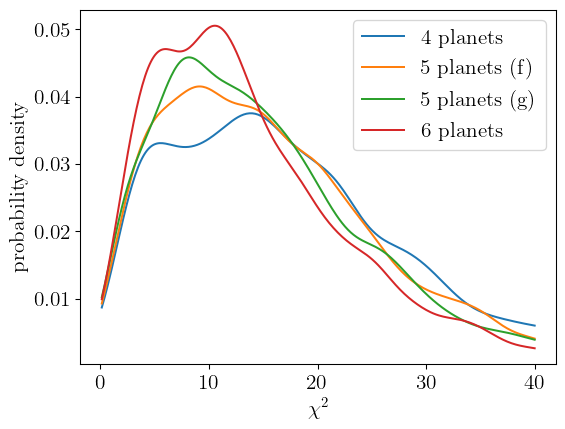

In [62]:
import scipy.stats as stats
#xx = np.linspace(np.min(all_chi2s), np.max(all_chi2s), 300)
xx = np.linspace(np.min(all_chi2s), 40, 300)
plt.plot(xx, stats.gaussian_kde(all_chi2s[0])(xx), label='4 planets')
plt.plot(xx, stats.gaussian_kde(all_chi2s[1])(xx), label='5 planets (f)')
plt.plot(xx, stats.gaussian_kde(all_chi2s[2])(xx), label='5 planets (g)')
plt.plot(xx, stats.gaussian_kde(all_chi2s[3])(xx), label='6 planets')
plt.xlabel("$\chi^2$")
plt.ylabel("probability density")
plt.legend()

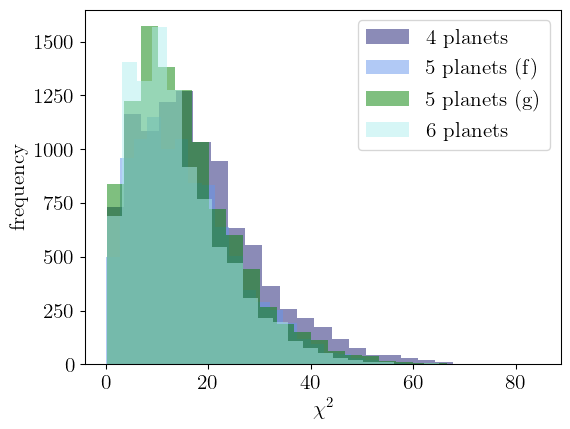

In [63]:
plt.hist(all_chi2s[0], bins=25, color='midnightblue', alpha=0.5, label='4 planets')
plt.hist(all_chi2s[1], bins=25, color='cornflowerblue', alpha=0.5, label='5 planets (f)')
plt.hist(all_chi2s[2], bins=25, color='green', alpha=0.5, label='5 planets (g)')
plt.hist(all_chi2s[3], bins=25, color='paleturquoise', alpha=0.5, label='6 planets')
plt.xlabel("$\chi^2$")
plt.ylabel("frequency")
plt.legend()